<span style="font-size:1.5em;">**Numerical methods for solving systems of chaotic first-order differential equations** </span>

"This study was made for an assignment of the class ”Numerical Methods with Applications to Ordinary and Partial Differential Equations” of my master’s program. For the assignment, a differential equation or a system of differential equations had to be chosen and solved using numerical methods and python.

Due to my interest in cryptology, I thought that studying differential equations that are
already used in cryptography would benefit me more than anything else and that’s why I chose
the ”Lorenz chaotic equations” for my project. Hence, at the start, this project aimed to solve
the Lorenz chaotic equations, as well as one of its extensions, using numerical methods (in
theory and in practice, using python). This though quickly changed to trying to solve ”all
chaotic systems of first-order differential equations” (in practice, by creating a python script
that can handle different function inputs for the system), which proved to be a much more
interesting goal."

This notebook is accompagnied by a pdf named "Numerical methods for solving systems of
chaotic first-order differential equations" which was created for this assignment too.  

Author: Florias Papadopoulos

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Numerical-Methods" data-toc-modified-id="Numerical-Methods-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Numerical Methods</a></span><ul class="toc-item"><li><span><a href="#Forward-Euler" data-toc-modified-id="Forward-Euler-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Forward Euler</a></span></li><li><span><a href="#4th-Order-Runge-Kutta" data-toc-modified-id="4th-Order-Runge-Kutta-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>4th Order Runge-Kutta</a></span></li><li><span><a href="#Backward-Euler-used-with-Newton-Raphson-method" data-toc-modified-id="Backward-Euler-used-with-Newton-Raphson-method-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Backward Euler used with Newton-Raphson method</a></span></li></ul></li><li><span><a href="#Some-applications" data-toc-modified-id="Some-applications-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Some applications</a></span><ul class="toc-item"><li><span><a href="#Comparison-of-the-methods" data-toc-modified-id="Comparison-of-the-methods-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Comparison of the methods</a></span></li><li><span><a href="#Creating-animation" data-toc-modified-id="Creating-animation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Creating animation</a></span></li></ul></li></ul></div>

# Numerical Methods

## Forward Euler

We are going to use the forward Euler method (FE for short) in order to solve the problem defined below:

"Assuming input of $n=3$ or $4$, $T>0$ (along with a natural number $M$ that defines the partition of $[0,T]$ into $M$ parts), the functions $f_1,\dots,f_n: \mathbb{R}^n \rightarrow \mathbb{R}$ and the initial values $\{x_1(0),\dots,x_n(0)\}$, solve and visualize the solutions of the system

\begin{equation*}
\left\{
\begin{aligned}
\dot{x_1} &= f_1(x_1,\dots,x_n) \\
          & \; \; \vdots\\
\dot{x_n} &= f_n(x_1,\dots,x_n), \\
\end{aligned}
\right.
\end{equation*}

where all state variables $x_1, \dots, x_n$ are depended on the time $t$ with $t \in [0,T]$."

### Importing modules

We start by importing the modules that we will use

In [1]:
import numpy as np
import sympy as sym
import math
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

If one or more modules are missing you can just type the code below in order to install a pip package in the current Jupyter kernel. For example, if numpy is missing, then we can use

In [1]:
import sys
!{sys.executable} -m pip install numpy


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\HP\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


### Defining the functions

#### Starter functions

##### (a) my_symbols function

Symbolic computations are done with symbols and SymPy variables are objects of Symbols class. Therefore, for our problem, We have to define a function that returns symbols of the form $(u_1,u_2,u_3)$ (similarly $(u_1,u_2,u_3,u_4)$, if $n=4$) in order to form the variables for our problem.

In [3]:
def my_symbols(n):
    if n == 3:
        x = sym.symbols("x1:4")
    if n == 4:
        x = sym.symbols("x1:5")
    return x

##### (b) my_matrix_function

As the user only inputs the functions $f_1,\dots,f_n$, we need to define a function that returns the matrix that contains the these functions,  
namely $f(x_1,\dots,x_n)=[ \; f_1(x_1,\dots,x_n) \; \cdots \; f_n(x_1,\dots,x_n) \, ]^T$.

In [4]:
def my_matrix_function(functions):
    #input: the functions f_1, ..., f_n

    list_of_functions = []
    for function in functions:
        list_of_functions.append(function)

    #the list above is made into a numpy array
    matrix_function = np.array(list_of_functions)

    #f is a column, so we need the transpose of the previous result
    matrix_function = np.transpose(matrix_function)

    #finally f is made into a SymPy matrix so that we can define it for different values of the variables
    matrix_function = sym.Matrix(matrix_function)

    return matrix_function

#### One instance Forward-Euler functions

Lets assume that we are on the $k$th iteration of the FE.  
We define two functions, one for $n=3$ and one for $n=4$, that use the forward Euler formula to give us the next value $X^{k+1}$, after we have inputed the previous value $X^{k}$. The FE formula is 

$$X^{k+1} = X^k + h \cdot f([X^k]^T),$$

with $X^k = [ \; x_1^k \, \cdots \, x_n^k \, ]^T$ and $f([X^k]^T)=[ \; f_1([X^k]^T) \, \cdots \, f_n([X^k]^T) \, ]^T$, for $k=0,\dots,M-1$.

In [5]:
#Case n=3
def forwardEuler3(variables,main_function_lamb,h,previous_values):
    #INPUT: the variables, the matrix_function defined previously after it has been "lambdified", the step-size h
    # and the previous_values X^k=(x_1^k, ..., x_3^k)^T

    #Calculating f(X^k)
    main_function_lamb = main_function_lamb(previous_values[0], previous_values[1],previous_values[2])

    #we transform the tuple previous_values into a numpy array in the form of a column
    previous_values = np.array(previous_values)[np.newaxis]
    previous_values = np.transpose(previous_values)

    #we use all the above to calculate the next_values X^{k+1}=(x_1^{k+1}, ..., x_3^{k+1} from the formula
    #and later transform them into a tuple
    next_values = previous_values + h*main_function_lamb
    next_values = np.transpose(next_values)
    next_values = next_values[0]
    next_values = tuple(next_values)

    return next_values

In [6]:
#Case n=4
def forwardEuler4(variables,main_function_lamb,h,previous_values):
    #INPUT: the variables, the matrix_function defined previously after it has been "lambdified", the step-size h
    # and the previous_values X^k=(x_1^k, ..., x_4^k)^T

    #Calculating f(X^k)
    main_function_lamb = main_function_lamb(previous_values[0], previous_values[1],previous_values[2],previous_values[3])

    #we transform the tuple previous_values into a numpy array in the form of a column
    previous_values = np.array(previous_values)[np.newaxis]
    previous_values = np.transpose(previous_values)

    #we use all the above to calculate the next_values X^{k+1}=(x_1^{k+1}, ..., x_4^{k+1} from the formula
    #and later transform them into a tuple
    next_values = previous_values + h*main_function_lamb
    next_values = np.transpose(next_values)
    next_values = next_values[0]
    next_values = tuple(next_values)

    return next_values

### Solving the problem

We have defined all functions needed to create the main function of the method, named "FE_function".  
The inputs of this function will be the user inputs defined in the problem and the output of this function will be a list of n-dimensional tuples which constitute the solution of the system through time.

In [7]:
def FE_function(variables, functions, previous_values, T, M):
 
    #from user inputs T and M, we calculate the step-size h
    h = T/M

    #we define the list of solutions which at start only includes the starting values at t=0
    solutions_list = [previous_values]

    #we use the second starter function to form the matrix function for the problem
    matrix_function = my_matrix_function(functions)

    #At this point, we branch out to two cases, depending on n
    #Case n=3
    if len(variables) == 3:
    
        #The lambdify function translates SymPy expressions into Python functions
        #in our case, this means that matrix_function_lamb can be given values for (x_1, x_2, x_3)
        matrix_function_lamb = sym.lambdify((x1,x2,x3),matrix_function)

        #the one instance RK function for n=3 has to be iterated for all instances k=0, ...,M
        #also, in python:  x in range(0,r+1) <=> x=0,1,...,r
        for z in range(0,M+1):
            previous_values = forwardEuler3(variables,matrix_function_lamb,h,previous_values)
            solutions_list.append(previous_values)

  #Case n=4
    if len(variables) == 4:
        matrix_function_lamb = sym.lambdify((x1,x2,x3,x4),matrix_function)
        
        for z in range(0,M+1):
            previous_values = forwardEuler4(variables,matrix_function_lamb,h,previous_values)
            solutions_list.append(previous_values)

    return solutions_list

### Example (Chaotic Lorenz system)

We will now show how all of the above can work in a working example for the chaotic Lorenz system

$$\left\{
\begin{aligned}
\frac{dx_1}{dt} &= \sigma(x_2-x_1) \\[0.5ex]
\frac{dx_2}{dt} &= x_1(\rho-x_3)-x_2 \\[0.5ex]
\frac{dx_3}{dt} &= x_1x_2-\beta x_3, \\[1.5ex]
\end{aligned}
\right.$$

with $\sigma = 10, \; \rho = 28 \text{ and } \beta = 2.667$.  
However, instead of simply printing the solutions, we show how they can be plotted with the help of the python module "matplotlib". 

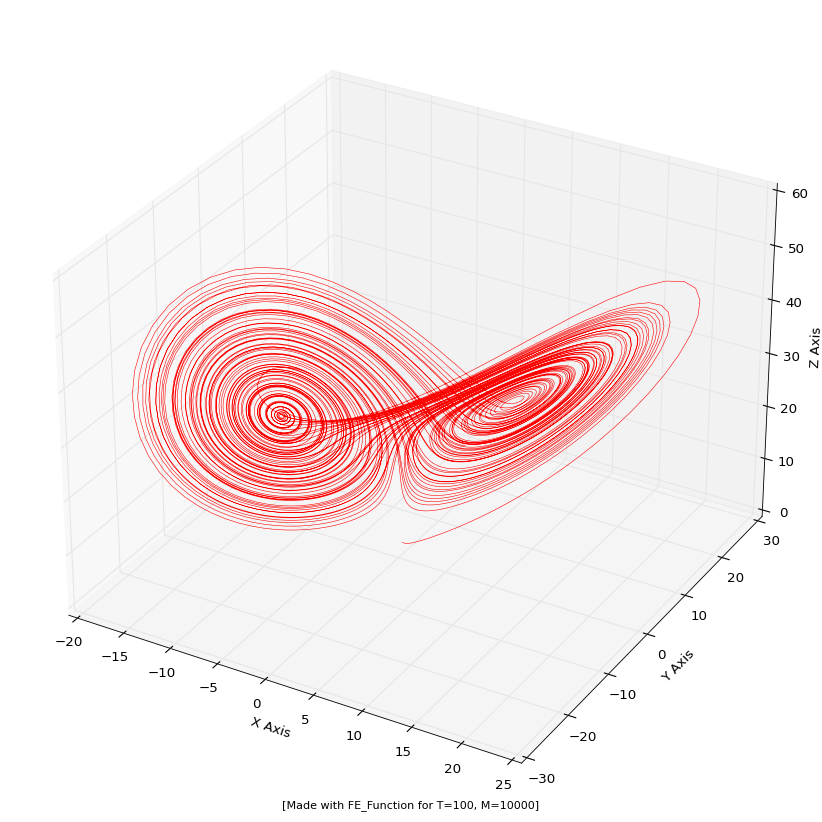

In [8]:
#user input, namely : T,M,n,functions,previous values
T = 100 #t is in [0,T]
M = 10000 #[0,T] is discretized in M equal parts
n=3 #the dimension of the system

(x1,x2,x3) = my_symbols(n) #needs to run after n input // the first starter function is used to form the three variables
variables = (x1,x2,x3) #needs to run after x_i creation

s, r, b = 10, 28, 2.667 #values for the parameters of the system
functions = (s*x2-s*x1, r*x1-x1*x3-x2, x1*x2-b*x3)
previous_values = (0,1,1)
#end of user input

#we find the list of the solutions using the main function
solutions = FE_function(variables, functions, previous_values, T, M)

#plotting

#with this command one can change the style of the plot (reminder: plt = pyplot)
plt.style.use('classic')

#creation of the figure, the "facecolor" command removes the default grey border of the figure
fig = plt.figure(figsize=((13,13)),facecolor="white")

#in order to add our values into the figure, we split each solution in its variable
x_plot = []
y_plot = []
z_plot = []
for sol in solutions:
    x_plot.append(sol[0])
    y_plot.append(sol[1])
    z_plot.append(sol[2])

#common definition for this pyplot function
ax = fig.add_subplot(projection='3d')

#definition of the plot using the lists of the "splitted" solutions
ax.plot(x_plot,y_plot,z_plot, color = 'red', linewidth=0.5)

#labels for each axis
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
plt.title(label="[Made with FE_Function for T=" + str(T) + ", "+ "M=" + str(M) + "]",
          fontsize=10,
          color="black", y=0.0)

#displays all open figures
plt.show()

## 4th Order Runge-Kutta

We are going to use the fourth order Runge-Kutta method (RK4 for short) in order to solve the problem defined below:

"Assuming input of $n=3$ or $4$, $T>0$ (along with a natural number $M$ that defines the partition of $[0,T]$ into $M$ parts), the functions $f_1,\dots,f_n: \mathbb{R}^n \rightarrow \mathbb{R}$ and the initial values $\{x_1(0),\dots,x_n(0)\}$, solve and visualize the solutions of the system

\begin{equation*}
\left\{
\begin{aligned}
\dot{x_1} &= f_1(x_1,\dots,x_n) \\
          & \; \; \vdots\\
\dot{x_n} &= f_n(x_1,\dots,x_n), \\
\end{aligned}
\right.
\end{equation*}

where all state variables $x_1, \dots, x_n$ are depended on the time $t$ with $t \in [0,T]$."

### Importing modules

We start by importing the modules that we will use

In [9]:
import numpy as np
import sympy as sym
import math
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

If one or more modules are missing you can just type the code below in order to install a pip package in the current Jupyter kernel. For example, if numpy is missing, then we can use

In [10]:
import sys
!{sys.executable} -m pip install numpy

### Defining the functions

#### Starter functions

##### (a) my_symbols function

Symbolic computations are done with symbols and SymPy variables are objects of Symbols class. Therefore, for our problem, We have to define a function that returns symbols of the form $(u_1,u_2,u_3)$ (similarly $(u_1,u_2,u_3,u_4)$, if $n=4$) in order to form the variables for our problem.

In [11]:
def my_symbols(n):
    if n == 3:
        x = sym.symbols("x1:4")
    if n == 4:
        x = sym.symbols("x1:5")
    return x

##### (b) my_matrix_function

As the user only inputs the functions $f_1,\dots,f_n$, we need to define a function that returns the matrix that contains the these functions,  
namely $f(x_1,\dots,x_n)=[ \; f_1(x_1,\dots,x_n) \; \cdots \; f_n(x_1,\dots,x_n) \, ]^T$.

In [12]:
def my_matrix_function(functions):
    #input: the functions f_1, ..., f_n

    list_of_functions = []
    for function in functions:
        list_of_functions.append(function)

    #the list above is made into a numpy array
    matrix_function = np.array(list_of_functions)

    #f is a column, so we need the transpose of the previous result
    matrix_function = np.transpose(matrix_function)

    #finally f is made into a SymPy matrix so that we can define it for different values of the variables
    matrix_function = sym.Matrix(matrix_function)

    return matrix_function

#### One instance Runge-Kutta functions

Lets assume that we are on the $k$th iteration of the RK4.  
We define two functions, one for $n=3$ and one for $n=4$, that use the 4th order Runge-Kutta formula to give us the next value $X^{k+1}$, after we have inputed the previous value $X^{k}$. The RK4 formula is 

$$X^{k+1} = X^k + \frac{h}{6} \cdot \left[ K_1 + 2K_2 + 2K_3 + K_4 \right],$$ with  
$X^k = [ \; x_1^k \, \cdots \, x_n^k \, ]^T$, $f([X^k]^T)=[ \; f_1([X^k]^T), \, \dots \, , f_n([X^k]^T) \, ]^T$ and $K_1 = f([X^k]^T), K_2 = f([X^k]^T + \frac{h}{2} K_1), K_3 = f([X^k]^T + \frac{h}{2} K_2), K_4 = f([X^k]^T + h K_3)$.

In [13]:
#Case n=3
def fourthOrderRungeKutta3(variables,matrix_function_lamb,h,previous_values):
    #INPUT: the variables, the matrix_function defined previously after it has been "lambdified", the step-size h
    # and the previous_values X^k=(x_1^k, ..., x_3^k)^T

    #calculating K1
    K1 = matrix_function_lamb(previous_values[0],previous_values[1],previous_values[2])

    #calculating K2
    K2 = matrix_function_lamb(previous_values[0]+(h/2)*K1[0][0],previous_values[1]+(h/2)*K1[1][0],previous_values[2]+(h/2)*K1[2][0])

    #calculating K3
    K3 = matrix_function_lamb(previous_values[0]+(h/2)*K2[0][0],previous_values[1]+(h/2)*K2[1][0],previous_values[2]+(h/2)*K2[2][0])

    #calculating K4
    K4 = matrix_function_lamb(previous_values[0]+h*K3[0][0],previous_values[1]+h*K3[1][0],previous_values[2]+h*K3[2][0])

    #we transform the tuple previous_values into a numpy array in the form of a column
    previous_values = np.array(previous_values)[np.newaxis]
    previous_values = np.transpose(previous_values)

    #we use all the above to calculate the next_values X^{k+1}=(x_1^{k+1}, ..., x_3^{k+1}) from the formula
    # and later transform them into a tuple
    next_values = previous_values + (h/6)*(K1+2*K2+2*K3+K4)
    next_values = np.transpose(next_values)
    next_values = next_values[0]
    next_values = tuple(next_values)

    return next_values

In [14]:
#Case n=4
def fourthOrderRungeKutta4(variables,matrix_function_lamb,h,previous_values):
    #INPUT: the variables, the matrix_function defined previously after it has been "lambdified", the step-size h
    # and the previous_values X^k=(x_1^k, ..., x_4^k)^T 

    #calculating K1
    K1 = matrix_function_lamb(previous_values[0], previous_values[1],previous_values[2],previous_values[3])

    #calculating K2
    K2 = matrix_function_lamb(previous_values[0]+(h/2)*K1[0][0],previous_values[1]+(h/2)*K1[1][0],previous_values[2]+(h/2)*K1[2][0],previous_values[3]+(h/2)*K1[3][0])

    #calculating K3
    K3 = matrix_function_lamb(previous_values[0]+(h/2)*K2[0][0],previous_values[1]+(h/2)*K2[1][0],previous_values[2]+(h/2)*K2[2][0],previous_values[3]+(h/2)*K2[3][0])

    #calculating K4
    K4 = matrix_function_lamb(previous_values[0]+h*K3[0][0],previous_values[1]+h*K3[1][0],previous_values[2]+h*K3[2][0],previous_values[3]+h*K3[3][0])

    #we transform the tuple previous_values into a numpy array in the form of a column
    previous_values = np.array(previous_values)[np.newaxis]
    previous_values = np.transpose(previous_values)

    #we use all the above to calculate the next_values X^{k+1}=(x_1^{k+1}, ..., x_4^{k+1} from the formula
    #and later transform them into a tuple
    next_values = previous_values + (h/6)*(K1+2*K2+2*K3+K4)
    next_values = np.transpose(next_values)
    next_values = next_values[0]
    next_values = tuple(next_values)

    return next_values

### Solving the problem

We have defined all functions needed to create the main function of the method, named "RK4_function".  
The inputs of this function will be the user inputs defined in the problem and the output of this function will be a list of n-dimensional tuples which constitute the solution of the system through time.

In [15]:
def RK4_function(variables, functions, previous_values, T, M):
 
    #from user inputs T and M, we calculate the step-size h
    h = T/M

    #we define the list of solutions which at start only includes the starting values at t=0
    solutions_list = [previous_values]

    #we use the second starter function to form the matrix function for the problem
    matrix_function = my_matrix_function(functions)

    #At this point, we branch out to two cases, depending on n
    #Case n=3
    if len(variables) == 3:
    
        #The lambdify function translates SymPy expressions into Python functions
        #in our case, this means that matrix_function_lamb can be given values for (x_1, x_2, x_3)
        matrix_function_lamb = sym.lambdify((x1,x2,x3),matrix_function)

        #the one instance RK function for n=3 has to be iterated for all instances k=0, ...,M
        #also, in python:  x in range(0,r+1) <=> x=0,1,...,r
        for z in range(0,M+1):
            previous_values = fourthOrderRungeKutta3(variables,matrix_function_lamb,h,previous_values)
            solutions_list.append(previous_values)

    #Case n=4
    if len(variables) == 4:
        matrix_function_lamb = sym.lambdify((x1,x2,x3,x4),matrix_function)
        for z in range(0,M+1):
            previous_values = fourthOrderRungeKutta4(variables,matrix_function_lamb,h,previous_values)
            solutions_list.append(previous_values)

    return solutions_list

### Example (Chaotic Lorenz system)

We will now show how all of the above can work in a working example for the chaotic Lorenz system

$$\left\{
\begin{aligned}
\frac{dx_1}{dt} &= \sigma(x_2-x_1) \\[0.5ex]
\frac{dx_2}{dt} &= x_1(\rho-x_3)-x_2 \\[0.5ex]
\frac{dx_3}{dt} &= x_1x_2-\beta x_3, \\[1.5ex]
\end{aligned}
\right.$$

with $\sigma = 10, \; \rho = 28 \text{ and } \beta = 2.667$.  
However, instead of simply printing the solutions, we show how they can be plotted with the help of the python module "matplotlib".

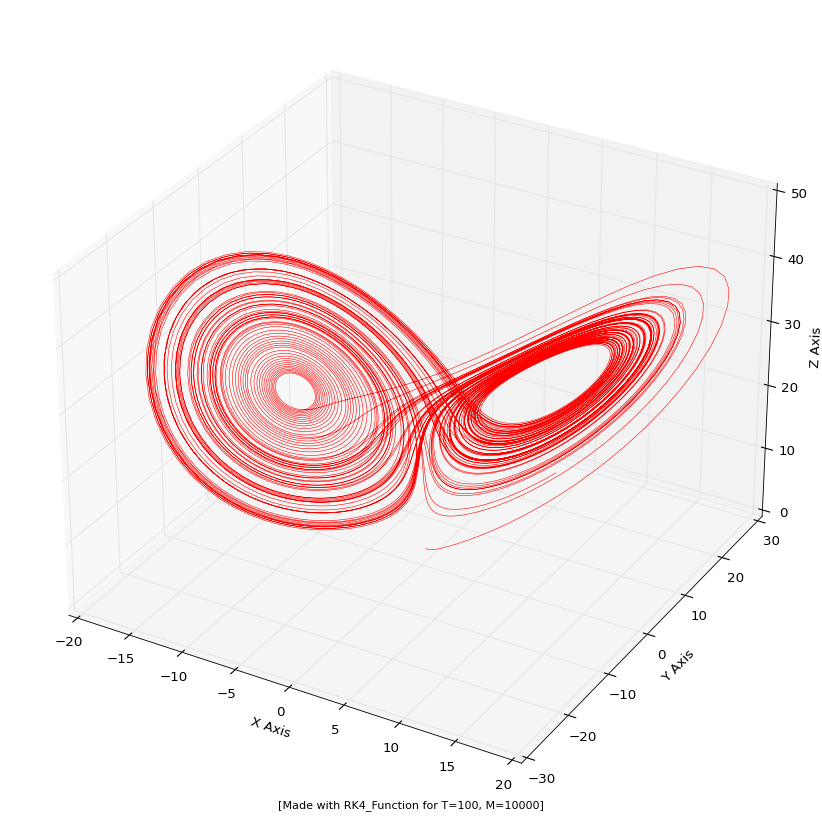

In [16]:
#user input, namely : T,M,n,functions,previous values
T = 100 #t is in [0,T]
M = 10000 #[0,T] is discretized in M equal parts
n=3 #the dimension of the system

(x1,x2,x3) = my_symbols(n) #needs to run after n input // the first starter function is used to form the three variables
variables = (x1,x2,x3) #needs to run after x_i creation

s, r, b = 10, 28, 2.667 #values for the parameters of the system
functions = (s*x2-s*x1, r*x1-x1*x3-x2, x1*x2-b*x3)
previous_values = (0,1,1)
#end of user input

#we find the list of the solutions using the main function
solutions = RK4_function(variables, functions, previous_values, T, M)

#plotting

#with this command one can change the style of the plot (reminder: plt = pyplot)
plt.style.use('classic')

#creation of the figure, the "facecolor" command removes the default grey border of the figure
fig = plt.figure(figsize=((13,13)),facecolor="white")

#in order to add our values into the figure, we split each solution in its variable
x_plot = []
y_plot = []
z_plot = []
for sol in solutions:
    x_plot.append(sol[0])
    y_plot.append(sol[1])
    z_plot.append(sol[2])

#common definition for this pyplot function
ax = fig.add_subplot(projection='3d')

#definition of the plot using the lists of the "splitted" solutions
ax.plot(x_plot,y_plot,z_plot, color = 'red', linewidth=0.5)

#labels for each axis
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
plt.title(label="[Made with RK4_Function for T=" + str(T) + ", "+ "M=" + str(M) + "]",
          fontsize=10,
          color="black", y=0.0)

#displays all open figures
plt.show()

## Backward Euler used with Newton-Raphson method

We are going to use the method above, which we will denote with BE, in order to solve the problem defined below:

"Assuming input of $n=3$ or $4$, $T>0$ (along with a natural number $M$ that defines the partition of $[0,T]$ into $M$ parts), the functions $f_1,\dots,f_n: \mathbb{R}^n \rightarrow \mathbb{R}$ and the initial values $\{x_1(0),\dots,x_n(0)\}$, solve and visualize the solutions of the system

\begin{equation*}
\left\{
\begin{aligned}
\dot{x_1} &= f_1(x_1,\dots,x_n) \\
          & \; \; \vdots\\
\dot{x_n} &= f_n(x_1,\dots,x_n), \\
\end{aligned}
\right.
\end{equation*}

where all state variables $x_1, \dots, x_n$ are depended on the time $t$ with $t \in [0,T]$."

### Importing modules

We start by importing the modules that we will use

In [17]:
import sys #needed to stop program if Newton doesnt converge
import numpy as np
import sympy as sym
import math
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

If one or more modules are missing you can just type the code below in order to install a pip package in the current Jupyter kernel. For example, if numpy is missing, then we can use

In [18]:
#import sys
!{sys.executable} -m pip install numpy

### Defining the functions

#### Starter functions

##### (a) my_symbols function

Symbolic computations are done with symbols and SymPy variables are objects of Symbols class. Therefore, for our problem, We have to define a function that returns symbols of the form $(u_1,u_2,u_3)$ (similarly $(u_1,u_2,u_3,u_4)$, if $n=4$) in order to form the variables for our problem.

In [19]:
def my_symbols(n):
    if n == 3:
        x = sym.symbols("x1:4")
    if n == 4:
        x = sym.symbols("x1:5")
        
    return x

##### (b) my_matrix_function

As the user only inputs the functions $f_1,\dots,f_n$, we need to define a function that returns the matrix that contains the these functions,  
namely $f(x_1,\dots,x_n)=[ \; f_1(x_1,\dots,x_n) \; \cdots \; f_n(x_1,\dots,x_n) \, ]^T$.

In [20]:
def my_matrix_function(functions):
    #input: the functions f_1, ..., f_n

    list_of_functions = []
    
    for function in functions:
        list_of_functions.append(function)
    
    #the list above is made into a numpy array
    matrix_function = np.array(list_of_functions)

    #f is a column, so we need the transpose of the previous result
    matrix_function = np.transpose(matrix_function)
  
    #finally f is made into a SymPy matrix so that we can define it for different values of the variables
    matrix_function = sym.Matrix(matrix_function)

    return matrix_function

##### (c) Jacobi_matrix

For the Newton method iterations of the program, we need a function that can compute the Jacobi matrix of a given matrix function $g=[ \; g_1 \, \cdots \, g_n \, ]^T$.  
The function below can do this by calculating the partial derivatives for each function $g_i$, which are equal to the $i$-line of the Jacobi matrix $J=\left(
\begin{array}{ccc}
\frac{\partial g_1}{\partial u_1} & \cdots & \frac{\partial g_1}{\partial u_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial g_1}{\partial u_1} & \cdots & \frac{\partial g_1}{\partial u_n} \\
\end{array} \right)$ of $g$, and then adding merging all the lines together to form $J$.

In [21]:
def Jacobi_matrix(variables, functions):

    #we create the empty list in which we will append every Derivative_line and later turn it into a matrix
    Derivatives = []

    #for each function g_i...
    for function in functions:
        
        #we set an empty list in which we will append each partial derivative
        Derivative_line = []

        #for every variable, we calculate the partial derivate of g_i and then append it into the list to create the line
        #for this we use the diff function of the SymPy module 
        for var in variables:
            Derivative_var = sym.diff(function,var)
            Derivative_line.append(Derivative_var)
        
        #we turn the Derivative_line list into an array
        Derivative_line = np.array(Derivative_line)
        
        #we append the Derivative_line in the list of Derivatives
        Derivatives.append(Derivative_line)

    #we trasnform the Derivatives list into a matrix
    Derivatives = np.array(Derivatives)

    return Derivatives

#### One instance Newton functions

On each iteration of the backward Euler method, we need to calculate the root of the matrix function $g$, defined by

$$g(X^{k+1}) \doteqdot X^{k+1} - X^k - h \cdot f([X^{k+1}]^T) = 0$$
or, by substituting 
$$g(U) \doteqdot U - X^k - h \cdot f(U^T) = 0,$$

where $X^k$ is known from the previous iteration and $X^{k+1}=U$ is the root that we are looking for. 

To calculate a good approximation of the root we will use the Raphson-Newton method.  
We will start by using an initial guess about the root of g (which we denote by $U^0=(u_1^0,\dots,u_n^0)$) and continue by trying to improve this initial guess of the root, according to the formula below, until we reach a sufficiently precise value

$$U^{s+1}=U^s-J^{-1}(U^s) \cdot g(U^s),$$

where $s=0,1,\dots$ and $J^{-1}$ is the inverse of the Jacobian matrix $J$ of $g$.

##### Notes:

1. *The "sufficiently precise value" mentioned above is decided by an appropriate stopping criterion, with a corresponding error. In our implementation of the method, we use the error value $e= \left[\sum_{i=0}^n \left( g_i(u_1^{k+1},\dots,u_n^{k+1}) - 0 \right)^2 \right]^{\frac{1}{2}}$, which is the Euclidean distance of $g$ from zero. In every step the error value $e$ will be calculated and the method will stop when $e$ falls below our chosen stop value ($10^{-12}$ in our program).  

2. For reasons of stability and computation time, instead of calculating the inverse of the Jacobian matrix $J$, we prefer to solve the matrix equation $J \cdot x = g(U^s)$, for each $s$.  

3. In order to increase the computing speed of the script we do some calculations outside the "Newton loop". For this reason, we define $q_i=x_i^{k+1}-h \cdot f_i(x_1^{k+1},\dots,x_n^{k+1})$ ("q_functions").  These functions are calculated outside the loop and are used as input in netwtonRoots.

In [22]:
#Case n=3
#could encounter convergence issues
def newtonRoots3(variables, q_functions, Jacobi_lamb, previous_values, initial_u):
    #INPUT:the variables, the q_functions,
    #the Jacobi_lamb, which is the Jacobi J after it has been "lambdified"
    #the previous_values, which is a tuple containing the values of X^k
    #and initial_u which is the tuple of the initial guess U^0

    #create the g_i functions from q_functions (g_i = q_i - x_i^k)
    g_functions = []
    for r in range(len(q_functions)):
        g_function_r = q_functions[r] + (-1)*previous_values[r]
        g_functions.append(g_function_r)
    
    #creating the matrix function g and lambdifying it
    g_functions = tuple(g_functions)
    g_function = my_matrix_function(g_functions)
    g_function = sym.Matrix(g_function)
    g_function_lamb = sym.lambdify((x1,x2,x3),g_function)
    
    #in this loop we will calculate U=X^{k+1} with error 10^-12 using initial_u
    #if this doesnt work after count=2000 iterations the program stops
    count = 0
    while True:

        #creating p = J^-1*g
        evaluated_Jacobi_lamb = Jacobi_lamb(initial_u[0],initial_u[1],initial_u[2])
        evaluated_g_function_lamb = g_function_lamb(initial_u[0],initial_u[1],initial_u[2])
        p_matrix = np.linalg.solve(evaluated_Jacobi_lamb, evaluated_g_function_lamb)
        minus_p_matrix = (-1) * p_matrix
        
        #transforming the initial_u tuple into an array column for the addition
        array_initial_u = np.array(initial_u)[np.newaxis]
        array_initial_u = np.transpose(array_initial_u)
        
        #calculating next_values and transforming them into a tuple
        next_values = array_initial_u + minus_p_matrix
        next_values = np.transpose(next_values)
        next_values = next_values[0]
        next_values = tuple(next_values)
        
        #initial_u (U^s) is next_values (U^{s+1})in the next iteration of the while loop
        initial_u = next_values

        #the stop criterion as explained in the third note
        count = count + 1
        stop_g_function_lamb = sym.lambdify((x1,x2,x3),g_function)
        stop_g_function_lamb = stop_g_function_lamb(next_values[0],next_values[1],next_values[2])
        dist_function_to_zero = np.linalg.norm(stop_g_function_lamb)
        
        #if next_values is not a good approximation of  X^{k+1} after 2000 tries, the program stops with error screen
        if count>2000 and dist_function_to_zero > pow(10,-12):
            sys.exit("Newton does not converge. Change initial_u or reduce accuracy to solve.")
        
        #if the errors falls below our set value 10^-12, the function returns next_values
        if dist_function_to_zero < pow(10,-12):
            break

    return next_values

In [23]:
#Case n=4
#could encounter convergence issues
def newtonRoots4(variables, q_functions, Jacobi_lamb, previous_values, initial_u):
    #INPUT:the variables, the q_functions,
    #the Jacobi_lamb, which is the Jacobi J after it has been "lambdified"
    #the previous_values, which is a tuple containing the values of X^k
    #and initial_u which is the tuple of the initial guess U^0

    #create the g_i functions from q_functions (g_i = q_i - x_i^k)
    g_functions = []
    for r in range(len(q_functions)):
        g_function_r = q_functions[r] + (-1)*previous_values[r]
        g_functions.append(g_function_r)
    
    #creating the matrix function g and lambdifying it
    g_functions = tuple(g_functions)
    g_function = my_matrix_function(g_functions)
    g_function = sym.Matrix(g_function)
    g_function_lamb = sym.lambdify((x1,x2,x3,x4),g_function)
    
    #in this loop we will calculate U=X^{k+1} with error 10^-12 using initial_u
    #if this doesnt work after count=2000 iterations, the program stops 
    count = 0
    while True:

        #creating p = J^-1*g
        evaluated_Jacobi_lamb = Jacobi_lamb(initial_u[0],initial_u[1],initial_u[2],initial_u[3])
        evaluated_g_function_lamb = g_function_lamb(initial_u[0],initial_u[1],initial_u[2],initial_u[3])
        p_matrix = np.linalg.solve(evaluated_Jacobi_lamb, evaluated_g_function_lamb)
        minus_p_matrix = (-1) * p_matrix
        
        #transforming the initial_u tuple into an array column for the addition
        array_initial_u = np.array(initial_u)[np.newaxis]
        array_initial_u = np.transpose(array_initial_u)
        
        #calculating next_values and transforming them into a tuple
        next_values = array_initial_u + minus_p_matrix
        next_values = np.transpose(next_values)
        next_values = next_values[0]
        next_values = tuple(next_values)
        
        #initial_u (U^s) is next_values (U^{s+1})in the next iteration of the while loop
        initial_u = next_values

        #the stop criterion as explained in the third note
        count = count + 1
        stop_g_function_lamb = sym.lambdify((x1,x2,x3,x4),g_function)
        stop_g_function_lamb = stop_g_function_lamb(next_values[0],next_values[1],next_values[2],next_values[3])
        dist_function_to_zero = np.linalg.norm(stop_g_function_lamb)
        
        #if next_values is not a good approximation of  X^{k+1} after 2000 tries, the program stops with error screen
        if count>2000 and dist_function_to_zero > pow(10,-12):
            sys.exit("Newton does not converge. Change initial_u or reduce accuracy to solve.")
        
        #if the errors falls below our set value 10^-12, the function returns next_values
        if dist_function_to_zero < pow(10,-12):
            break

    return next_values

### Solving the problem

We have defined all functions needed to create the main function of the method, named "BE_function".  
The inputs of this function will be the user inputs defined in the problem and the output of this function will be a list of n-dimensional tuples which constitute the solution of the system through time.

In [24]:
def BE_function(variables, functions, previous_values, T, M, initial_u):

    #from user inputs T and M, we calculate the step-size h
    h = T/M

    #we define the list of solutions which at start only includes the starting values at t=0
    solutions_list = [previous_values]
    
    #we form the q_functions, where q_i = x_i^{k+1} -h*f_i(x_1^{k+1},...,x_n^{k+1})
    q_functions = []
    for i in range(len(variables)):
        q_function_i = variables[i] + (-h)*functions[i]
        q_functions.append(q_function_i)
    q_functions = tuple(q_functions)

    #we will calculate the Jacobi matrix of q, which is equal to the Jacobi matrix J of g
    Jacobi = Jacobi_matrix(variables,q_functions)
    Jacobi = sym.Matrix(Jacobi)

    #n=3
    if len(variables) == 3:
        
        Jacobi_lamb = sym.lambdify((x1,x2,x3),Jacobi)

        for z in range(0,M+1):
            next_values = newtonRoots3(variables, q_functions, Jacobi_lamb, previous_values, initial_u)
            previous_values = next_values
            solutions_list.append(next_values)

            #although the first initial_u is chosen by us, all that follow should stay close to the "curve"
            #so, we set it equal to next_values
            initial_u = next_values
            
    #n=4
    if len(variables) == 4:
        
        Jacobi_lamb = sym.lambdify((x1,x2,x3,x4),Jacobi)

        for z in range(0,M+1):
            next_values = newtonRoots4(variables, q_functions, Jacobi_lamb, previous_values, initial_u)
            previous_values = next_values
            solutions_list.append(next_values)

            #although the first initial_u is chosen by us, all that follow should stay close to the "curve"
            #so, we set it equal to next_values
            initial_u = next_values

    return solutions_list

### Example (Chaotic Lorenz system)

We will now show how all of the above can work in a working example for the chaotic Lorenz system

$$\left\{
\begin{aligned}
\frac{dx_1}{dt} &= \sigma(x_2-x_1) \\[0.5ex]
\frac{dx_2}{dt} &= x_1(\rho-x_3)-x_2 \\[0.5ex]
\frac{dx_3}{dt} &= x_1x_2-\beta x_3, \\[1.5ex]
\end{aligned}
\right.$$

with $\sigma = 10, \; \rho = 28 \text{ and } \beta = 2.667$.  
However, instead of simply printing the solutions, we show how they can be plotted with the help of the python module "matplotlib".

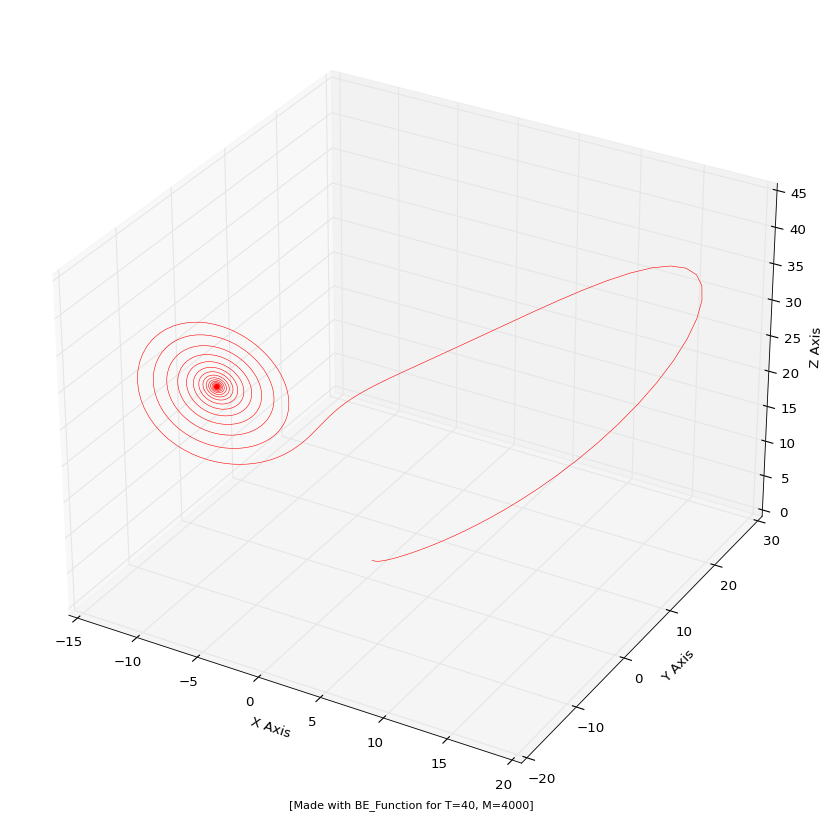

In [25]:
#user input, namely : T,M,n,functions,previous values
T = 40 #t is in [0,T]
M = 4000 #[0,T] is discretized in M equal parts
n=3 #the dimension of the system

(x1,x2,x3) = my_symbols(n) #needs to run after n input // the first starter function is used to form the three variables
variables = (x1,x2,x3) #needs to run after x_i creation

s, r, b = 10, 28, 2.667 #values for the parameters of the system
functions = (s*x2-s*x1, r*x1-x1*x3-x2, x1*x2-b*x3)
previous_values = (0,1,1)
initial_u = (1.1,1.1,1.1)
#end of user input

#we find the list of the solutions using the main function
solutions = BE_function(variables, functions, previous_values, T, M, initial_u)

#plotting

#with this command one can change the style of the plot (reminder: plt = pyplot)
plt.style.use('classic')

#creation of the figure, the "facecolor" command removes the default grey border of the figure
fig = plt.figure(figsize=((13,13)),facecolor="white")

#in order to add our values into the figure, we split each solution in its variable
x_plot = []
y_plot = []
z_plot = []
for sol in solutions:
    x_plot.append(sol[0])
    y_plot.append(sol[1])
    z_plot.append(sol[2])

#common definition for this pyplot function
ax = fig.add_subplot(projection='3d')

#definition of the plot using the lists of the "splitted" solutions
ax.plot(x_plot,y_plot,z_plot, color = 'red', linewidth=0.5)

#labels for each axis
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
plt.title(label="[Made with BE_Function for T=" + str(T) + ", "+ "M=" + str(M) + "]",
          fontsize=10,
          color="black", y=0.0)

#displays all open figures
plt.show()

# Some applications

## Comparison of the methods

### In the same figure

We assume once again the chaotic Lorenz system

$$\left\{
\begin{aligned}
\frac{dx_1}{dt} &= \sigma(x_2-x_1) \\[0.5ex]
\frac{dx_2}{dt} &= x_1(\rho-x_3)-x_2 \\[0.5ex]
\frac{dx_3}{dt} &= x_1x_2-\beta x_3, \\[1.5ex]
\end{aligned}
\right.$$

with $\sigma = 10, \; \rho = 28 \text{ and } \beta = 2.667$.
For this application, we would like to create a script that can plot the Chaotic Lorenz system with all of the numerical methods, in the same figure, using "matplotlib".  
-All previous functions need to be on the kernel in order to use them in this example-

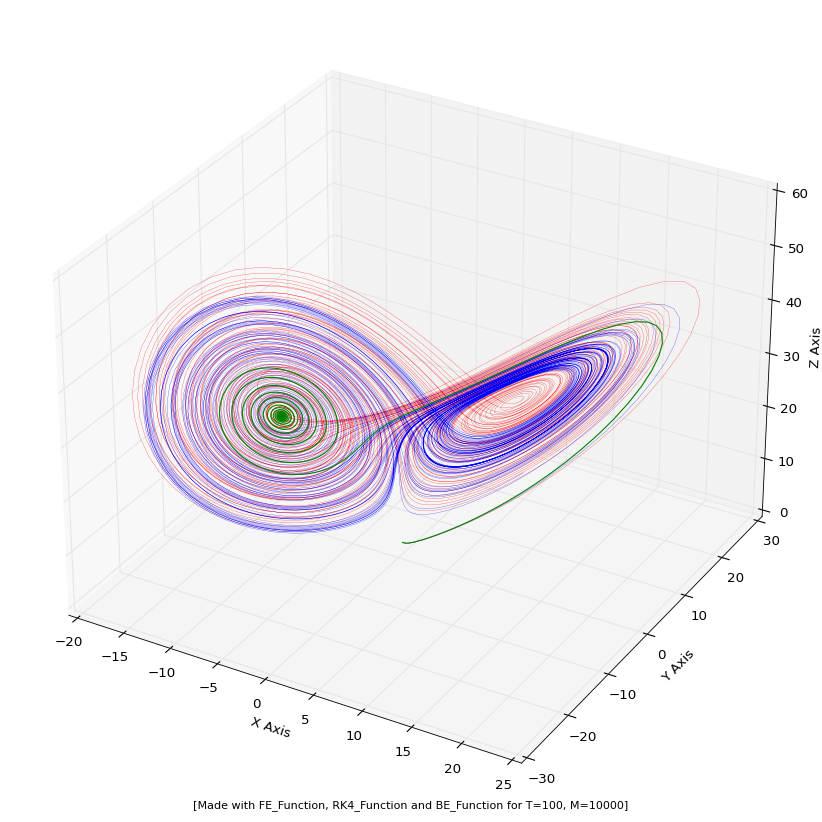

In [26]:
#user input, namely : T,M,n,functions,previous values
T = 100 #t is in [0,T]
M = 10000 #[0,T] is discretized in M equal parts
n=3 #the dimension of the system

(x1,x2,x3) = my_symbols(n) #needs to run after n input // the first starter function is used to form the three variables
variables = (x1,x2,x3) #needs to run after x_i creation

s, r, b = 10, 28, 2.667 #values for the parameters of the system
functions = (s*x2-s*x1, r*x1-x1*x3-x2, x1*x2-b*x3)
previous_values = (0,1,1)

initial_u = (1.1, 1.1, 1.1) #needed only for the BE_function
#end of user input

#we find the list of the solutions using the main function
solutions_FE = FE_function(variables, functions, previous_values, T, M)
solutions_RK4 = RK4_function(variables, functions, previous_values, T, M)
solutions_BE = BE_function(variables, functions, previous_values, T, M, initial_u)

#plotting

#with this command one can change the style of the plot (reminder: plt = pyplot)
plt.style.use('classic')

#creation of the figure, the "facecolor" command removes the default grey border of the figure
fig = plt.figure(figsize=((13,13)),facecolor="white")

#common definition for this pyplot function
ax = fig.add_subplot(projection='3d')

#labels for each axis
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
plt.title(label="[Made with FE_Function, RK4_Function and BE_Function for T=" + str(T) + ", "+ "M=" + str(M) + "]",
          fontsize=10,
          color="black", y=0.0)

#for forward Euler in red
#in order to add our values into the figure, we split each solution in its variable
x_plot = []
y_plot = []
z_plot = []
for sol in solutions_FE:
    x_plot.append(sol[0])
    y_plot.append(sol[1])
    z_plot.append(sol[2])

#definition of the plot using the lists of the "splitted" solutions
ax.plot(x_plot,y_plot,z_plot, color = 'red', linewidth=0.2)

#for 4th order Runge-Kutta in blue
#in order to add our values into the figure, we split each solution in its variable
x_plot = []
y_plot = []
z_plot = []
for sol in solutions_RK4:
    x_plot.append(sol[0])
    y_plot.append(sol[1])
    z_plot.append(sol[2])

#definition of the plot using the lists of the "splitted" solutions
ax.plot(x_plot,y_plot,z_plot, color = 'blue', linewidth=0.2)

#for backward Euler in green
#in order to add our values into the figure, we split each solution in its variable
x_plot = []
y_plot = []
z_plot = []
for sol in solutions_BE:
    x_plot.append(sol[0])
    y_plot.append(sol[1])
    z_plot.append(sol[2])

#definition of the plot using the lists of the "splitted" solutions
#linewidth a bit larger here for better visuals
ax.plot(x_plot,y_plot,z_plot, color = 'green', linewidth=1)

#displays all open figures
plt.show()

### In different figures

We assume once again the chaotic Lorenz system

$$\left\{
\begin{aligned}
\frac{dx_1}{dt} &= \sigma(x_2-x_1) \\[0.5ex]
\frac{dx_2}{dt} &= x_1(\rho-x_3)-x_2 \\[0.5ex]
\frac{dx_3}{dt} &= x_1x_2-\beta x_3, \\[1.5ex]
\end{aligned}
\right.$$

with $\sigma = 10, \; \rho = 28 \text{ and } \beta = 2.667$.
For this application, we would like to create a script that can plot the Chaotic Lorenz system with all of the numerical methods, in different figures, using "matplotlib".  
-All previous functions need to be on the kernel in order to use them in this example-

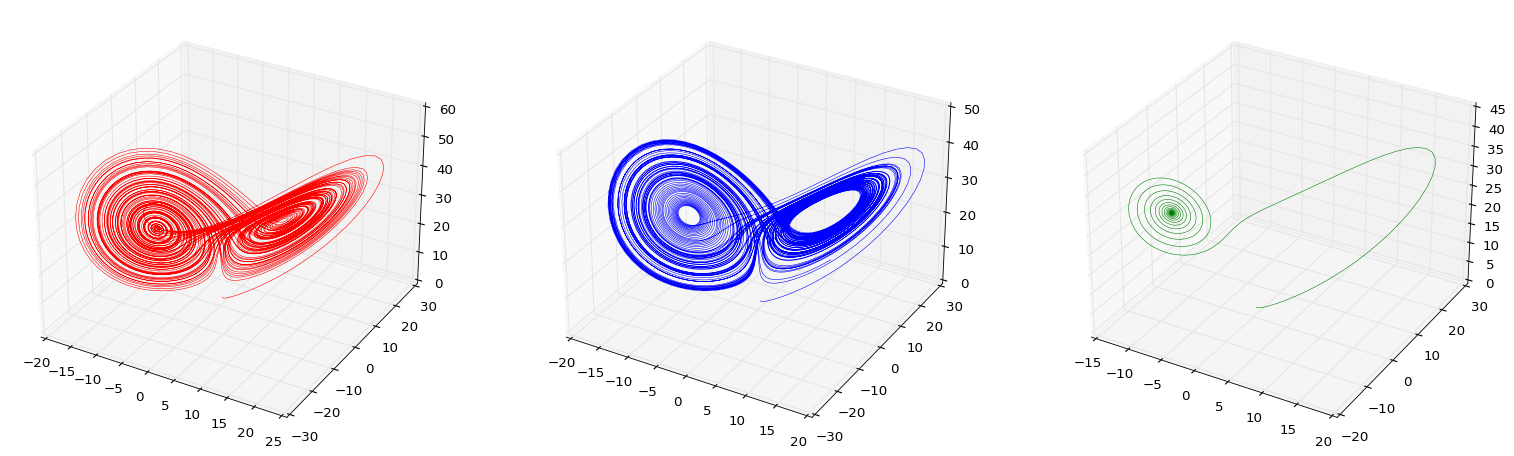

In [27]:
#we will need gridspec in order to have separated figures
import matplotlib.gridspec as gridspec

#user input, namely : T,M,n,functions,previous values
T = 100 #t is in [0,T]
M = 10000 #[0,T] is discretized in M equal parts
n=3 #the dimension of the system

(x1,x2,x3) = my_symbols(n) #needs to run after n input // the first starter function is used to form the three variables
variables = (x1,x2,x3) #needs to run after x_i creation

s, r, b = 10, 28, 2.667 #values for the parameters of the system
functions = (s*x2-s*x1, r*x1-x1*x3-x2, x1*x2-b*x3)
previous_values = (0,1,1)

initial_u = (1.1, 1.1, 1.1) #needed only for the BE_function
#end of user input

#we find the list of the solutions using the main function
solutions_FE = FE_function(variables, functions, previous_values, T, M)
solutions_RK4 = RK4_function(variables, functions, previous_values, T, M)
solutions_BE = BE_function(variables, functions, previous_values, T, M, initial_u)

#plotting

#with this command one can change the style of the plot (reminder: plt = pyplot)
plt.style.use('classic')

#creating the grid for the three figures
gs = gridspec.GridSpec(1, 3)

#creation of the "figure", the "facecolor" command removes the default grey border of the figure
#in this case, figsize needs to be of the form (3x,x) because we have 3 figures that we want to fit horizontally
fig = plt.figure(figsize=((24,8)),facecolor="white")

#common definition for this pyplot function
#we need three of them, one for each figure, using gridspec too
ax00 = fig.add_subplot(gs[0,0], projection='3d')
ax01 = fig.add_subplot(gs[0,1], projection='3d')
ax02 = fig.add_subplot(gs[0,2], projection='3d')

#labels for each axis
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")

#for forward Euler in red
#in order to add our values into the figure, we split each solution in its variable
x_plot = []
y_plot = []
z_plot = []
for sol in solutions_FE:
    x_plot.append(sol[0])
    y_plot.append(sol[1])
    z_plot.append(sol[2])

#definition of the plot using the lists of the "splitted" solutions
#ax00 because we want it to be the first figure
ax00.plot(x_plot,y_plot,z_plot, color = 'red', linewidth=0.5)

#for 4th order Runge-Kutta in blue
#in order to add our values into the figure, we split each solution in its variable
x_plot = []
y_plot = []
z_plot = []
for sol in solutions_RK4:
    x_plot.append(sol[0])
    y_plot.append(sol[1])
    z_plot.append(sol[2])

#definition of the plot using the lists of the "splitted" solutions
#ax01 because we want it to be the second figure
ax01.plot(x_plot,y_plot,z_plot, color = 'blue', linewidth=0.5)

#for backward Euler in green
#in order to add our values into the figure, we split each solution in its variable
x_plot = []
y_plot = []
z_plot = []
for sol in solutions_BE:
    x_plot.append(sol[0])
    y_plot.append(sol[1])
    z_plot.append(sol[2])

#definition of the plot using the lists of the "splitted" solutions
#ax02 because we want it to be the third figure
ax02.plot(x_plot,y_plot,z_plot, color = 'green', linewidth=0.5)

#displays all open figures
plt.show()

## Creating animation

We remind again the chaotic Lorenz system

$$\left\{
\begin{aligned}
\frac{dx_1}{dt} &= \sigma(x_2-x_1) \\[0.5ex]
\frac{dx_2}{dt} &= x_1(\rho-x_3)-x_2 \\[0.5ex]
\frac{dx_3}{dt} &= x_1x_2-\beta x_3, \\[1.5ex]
\end{aligned}
\right.$$

with $\sigma = 10, \; \rho = 28 \text{ and } \beta = 2.667$.
For this application, we would like to use the 4th order Runge-Kutta method, in order to create an animation of the solutions of the system in time $[0,T]$, using "matplotlib" and "matplotlib.animation".  
-All previous functions need to be on the kernel in order to use them in this example-

In [2]:
#we need these for the animation
import matplotlib.animation as animation
from IPython import display

#this line is crucial for the animation to work and be interactive
%matplotlib notebook

#user input, namely : T,M,n,functions,previous values
T = 100 #t is in [0,T]
M = 10000 #[0,T] is discretized in M equal parts
n=3 #the dimension of the system

(x1,x2,x3) = my_symbols(n) #needs to run after n input // the first starter function is used to form the three variables
variables = (x1,x2,x3) #needs to run after x_i creation

s, r, b = 10, 28, 2.667 #values for the parameters of the system
functions = (s*x2-s*x1, r*x1-x1*x3-x2, x1*x2-b*x3)
previous_values = (0,1,1)
#end of user input

#we find the list of the solutions using the main function
solutions = RK4_function(variables, functions, previous_values, T, M)

#plotting

#with this command one can change the style of the plot (reminder: plt = pyplot)
plt.style.use('classic')

#in order to add our values into the figure, we split each solution in its variable
x_plot = []
y_plot = []
z_plot = []
for sol in solutions:
    x_plot.append(sol[0])
    y_plot.append(sol[1])
    z_plot.append(sol[2])
    
# ==============================================================
# initial conditions of (x1, x2, x3) at t = 0
y0 = np.array(previous_values)

# ==============================================================
# propagate state

# simulation results
state_history = []

# initialize yk
yk = y0

# intialize time
t = 0

# iterate over time
h = T/M 
for t in range(0,M,1):
    # save current state
    state_history.append(yk)

    # update state variables yk to yk+1
    list_xyz = []
    list_xyz.append(x_plot[t])
    list_xyz.append(y_plot[t])
    list_xyz.append(z_plot[t])
    yk = np.array(list_xyz)

# convert list to numpy array
state_history = np.array(state_history)

# ==============================================================
# plot history

fig = plt.figure()  # figsize=(10, 8)
ax = plt.axes(projection='3d')
ax.set_xlim3d(min(state_history[:, 0]) - 0.05, max(state_history[:, 0]) + 0.05)
ax.set_ylim3d(min(state_history[:, 1]) - 0.05, max(state_history[:, 1]) + 0.05)
ax.set_zlim3d(min(state_history[:, 2]) - 0.05, max(state_history[:, 2]) + 0.05)

# trajectory data to plot
trajectory, = ax.plot([], [], [], linewidth=0.3, color = "red")

ax.set(xlabel='X', ylabel='Y', zlabel='Z', title='The Lorenz Equations - "Lorenz Attractor Simulation"')
ax.xaxis.set_pane_color((0.25, 0.25, 0.2, 0.4))
ax.yaxis.set_pane_color((0.25, 0.25, 0.2, 0.4))
ax.zaxis.set_pane_color((0.25, 0.25, 0.2, 0.4))
ax.grid()

def animate(i):
    # update axis view angle
    i -= M * (i//M)

    # update trajectory for current time step
    trajectory.set_data(state_history[:i, 0], state_history[:i, 1])
    trajectory.set_3d_properties(state_history[:i, 2])
    return trajectory,


# show animation

anim = animation.FuncAnimation(fig, animate, frames=10000, 
                                   interval=2, blit=False)

NameError: name 'my_symbols' is not defined